In [1]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import HumanMessage, ToolMessage, BaseMessage, SystemMessage
from operator import add as add_messages
from langchain_mistralai import ChatMistralAI, MistralAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

load_dotenv()
model = ChatMistralAI(model_name="mistral-medium-latest")
embedding = MistralAIEmbeddings(model="mistral-embed")


e:\Project\Job-Recommender-System\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pdf_path = "test_file.pdf"

In [3]:
# load the fle
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"{pdf_path} not found.")
pdf_loader = PyPDFLoader(pdf_path)

In [4]:
# load the pages
try:
    pages = pdf_loader.load()
    print(f"Pdf has loaded, pages: {len(pages)}")
except Exception as e:
    print(f"an error while loading docs {e}")

Pdf has loaded, pages: 9


In [5]:
# test splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200
)

In [6]:
chunks = text_splitter.split_documents(pages)
print(f"total number of pages: {len(chunks)}")

total number of pages: 18


In [7]:
# vector database
collection_name = "test-document-store"

try:
    vectorstore = Chroma.from_documents(
        documents = chunks,
        embedding = embedding,
        collection_name = collection_name
    )
    print(f"vs created with collection name {collection_name}")
except Exception as e:
    print(f"error has from creaing vs.")

vs created with collection name test-document-store


In [8]:
retriever = vectorstore.as_retriever(
    search_type = "similarity",
    search_kewargs = {"k": 3}
)

In [9]:
@tool
def retriever_tool(query: str) -> str:
    """ this tool search and return information from the vectorstore """
    docs = retriever.invoke(query)
    if not docs:
        return "No relavent information found in the document."
    results = []
    for i, doc in enumerate(docs):
        results.append(f"source {i+1}:\n{doc.page_content}\n")
    return "\n".join(results)

tool = [retriever_tool]
llm = model.bind_tools(tool)

In [10]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [11]:
def should_continue(state: AgentState):
    """ check if the last message contains tool calls """
    last_message = state['messages'][-1]
    return hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0

In [12]:
system_prompt = """
you are an intelligent AI assistant who answers quesions bases on the PDF document.
"""

In [13]:
tool_dict = {our_tool.name: our_tool for our_tool in tool}
print(tool_dict)

{'retriever_tool': StructuredTool(name='retriever_tool', description='this tool search and return information from the vectorstore', args_schema=<class 'langchain_core.utils.pydantic.retriever_tool'>, func=<function retriever_tool at 0x00000236E511FD80>)}


In [14]:
# llm agent
def call_llm(state: AgentState) -> AgentState:
    """ funcion to call the llm with th current state """
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

In [15]:
# retriever agent
def take_action(state: AgentState) -> AgentState:
    """ function to execute tools from the llm's response """
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Executing tool: {t['name']} with input {t['args']}")
        if not t['name'] in tool_dict:
            result=(f"Tool {t['name']} not found")
        else:
            result = tool_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Tool result: {result}")

        results.append(
            ToolMessage(
                tool_call_id = t['id'],
                name = t['name'],
                content = str(result)
            )
        )

    print("tools excecuted.")
    return {"messages": results}


In [16]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)
graph.add_edge(START, 'llm')
graph.add_conditional_edges(
    'llm',
    should_continue, 
    {
        True: 'retriever_agent',
        False: END
    }
)
graph.add_edge("retriever_agent", "llm")

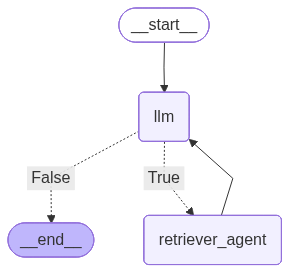

In [17]:
rag_agent = graph.compile()
rag_agent

In [18]:
def running_agent():
    while True:
        user_input = input("what is your quesuion?")
        if user_input.lower() in ['exit', 'quit']:
            print('exiting the Agent...')
            break
        messages = [HumanMessage(content=user_input)]
        result = rag_agent.invoke({'messages': messages})
        print("agent response: ")
        print(result['messages'][-1].content)
        
running_agent()


Executing tool: retriever_tool with input {'query': 'What is this document about?'}
Tool result: source 1:
A Brief Introduction to Artificial IntelligenceWhat is AI and how is it going to shape the futureBy Dibbyo Saha, Undergraduate Student, Computer Science,Ryerson University
What is Artificial Intelligence?
Image by Gerd Altmann from Pixabay

source 2:
[3]
Elon Musk and some others founded OpenAI in 2015.
[4][5]
Artificial Intelligence vs Machine Learning vs DeepLearning
Image by Gerd Altmann from Pixabay 
Up until nowin this article we were discussing about Artificial Intelligence as aprocess that isgoingtohelpmachinesachieveahumanlikementalbehaviour.AIisa vast and growing field which also includes a lot more subfields like machinelearninganddeeplearningandsoon.Machinelearningisinanutshelltheconceptof computers learning to improve their predictions and creativity to resemble ahumanlikethinkingprocess usingalgorithms. Machinelearninginvolvesanumberof learning processes such as:
Supe